# RandomForestClassifier

$ pip install graphviz

In [24]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from sklearn.preprocessing import StandardScaler
# importing random forest classifier from assemble module
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import randint
from imblearn.ensemble import BalancedRandomForestClassifier

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Save models
import joblib

import random
random.seed(2024)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
# from sklearn 0.19.2 documentation:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
# Load data file
uq_path = "/Users/radhi/Desktop/CAPSTONE_DATA/NEK_data_4Berkeley/NEK3" 
train_x_df = pd.read_csv(uq_path+"/NEK3_binding_random_fold1_trainX.csv")
train_y_df = pd.read_csv(uq_path+"/NEK3_binding_random_fold1_trainY.csv")
test_x_df = pd.read_csv(uq_path+"/NEK3_binding_random_fold1_testX.csv")
test_y_df = pd.read_csv(uq_path+"/NEK3_binding_random_fold1_testY.csv")
test_x_df

,ASA+_per_atom,ASA-,ASA_H_per_atom,ASA_P,ASA_per_atom,BCUT_PEOE_0,BCUT_PEOE_1,BCUT_PEOE_2,BCUT_PEOE_3,BCUT_SLOGP_0_per_atom,...,vsurf_Wp2_per_atom,vsurf_Wp3,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,vsurf_Wp8,weinerPath,weinerPol_per_atom,zagreb_per_atom
0,10.215013,142.21526,6.836120,244.47214,15.890644,-2.194154,-0.719023,0.731004,2.217017,-0.086358,...,21.333333,243.750,81.125,33.000,10.000,0.750,0.000,513,0.925926,3.407407
1,7.736764,220.71700,7.970176,205.31177,11.080960,-2.681831,-0.546122,0.637987,2.689039,-0.052606,...,9.878788,205.000,42.250,14.000,4.375,0.375,0.000,3825,0.878788,2.939394
2,8.211856,304.34698,8.814355,271.20950,13.745438,-2.403042,-0.574742,0.596937,2.408815,-0.042698,...,12.236364,216.750,48.000,19.125,5.750,0.250,0.000,4067,0.909091,3.200000
3,8.901980,195.95447,8.445429,222.74628,13.395346,-2.583713,-0.575453,0.617978,2.567737,-0.057201,...,12.941667,216.250,63.125,26.000,8.000,1.000,0.000,1508,0.933333,3.066667
4,7.612832,287.15073,9.292597,194.76367,12.833755,-2.537550,-0.628175,0.660120,2.707292,-0.049639,...,9.900000,152.500,44.750,19.875,7.750,1.000,0.375,3569,0.818182,3.018182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,10.206247,174.56108,11.438849,117.39546,13.786759,-2.647072,-0.620867,0.690330,2.605075,-0.055629,...,11.690000,112.750,19.250,8.375,2.625,0.125,0.000,2944,0.880000,3.200000
278,8.224840,221.81551,10.469413,138.76630,14.219854,-2.554365,-0.615955,0.599157,2.565347,-0.088887,...,13.371622,159.875,43.250,14.125,2.250,0.000,0.000,975,0.810811,2.918919
279,8.642949,161.90437,8.153549,186.68533,12.940353,-2.492239,-0.584590,0.657366,2.468000,-0.066054,...,11.259615,138.875,37.250,13.875,3.500,0.250,0.000,1301,0.846154,3.025641
280,7.236550,241.08192,7.003955,254.33978,11.466057,-2.665590,-0.491930,0.530384,2.600261,-0.048795,...,8.043860,118.500,19.125,7.250,2.250,0.000,0.000,4011,0.982456,3.333333


In [5]:
# Transform data to PyTorch tensors

# Scale data
x_df = pd.concat([train_x_df, test_x_df])

scaling=StandardScaler()
 
# Use fit and transform method 
scaling.fit(x_df)
Scaled_data=scaling.transform(x_df)
train_x = scaling.transform(train_x_df)
test_x = scaling.transform(test_x_df) 

train_y = train_y_df.to_numpy().flatten()
test_y = test_y_df.to_numpy().flatten()

print(train_x.shape)
print(train_y.shape)

(1122, 306)
(1122,)


In [6]:
# Construct a RF classification model

# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 100)  
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(train_x, train_y)
 
# performing predictions on the test dataset
test_pred_y = clf.predict(test_x)




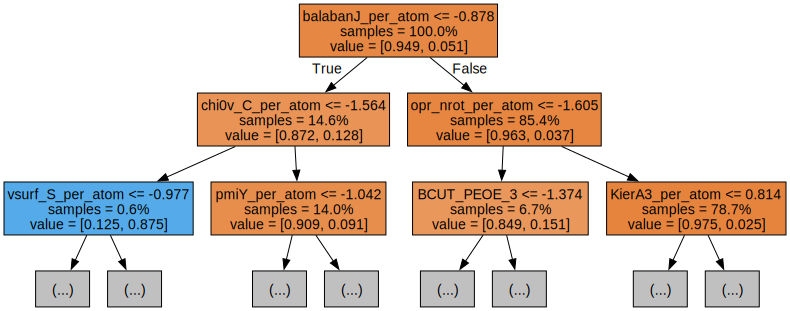

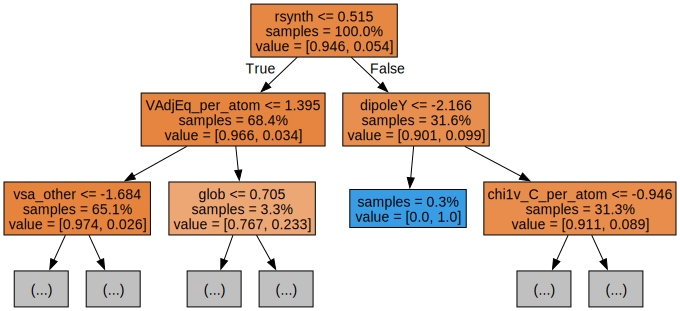

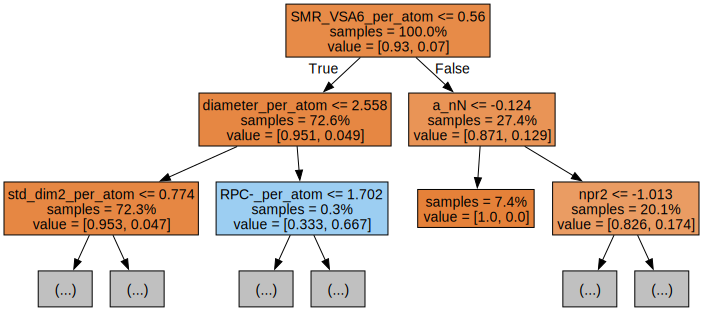

In [7]:
# Export the first three decision trees from the forest

for i in range(3):
    tree = clf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=train_x_df.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Confusion matrix, without normalization
[[265   0]
 [ 17   0]]


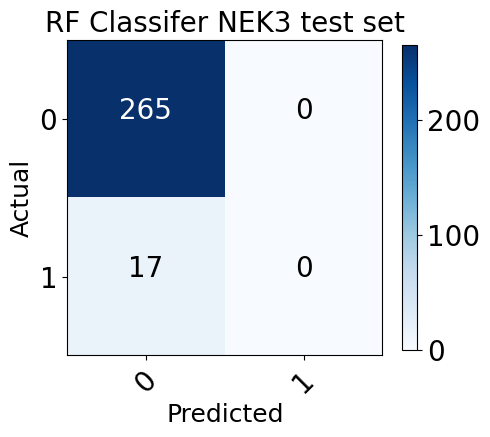

In [8]:
# Create the confusion matrix
test_cm = confusion_matrix(test_y, test_pred_y)

class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("RF Classifer NEK3 test set",fontsize=20)
plot_confusion_matrix(test_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);



## Hyperparameter tuning

In [9]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,50)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(train_x, train_y)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2822433d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2a94e6ca0>})

In [10]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 25, 'n_estimators': 206}


Confusion matrix, without normalization
[[265   0]
 [ 17   0]]


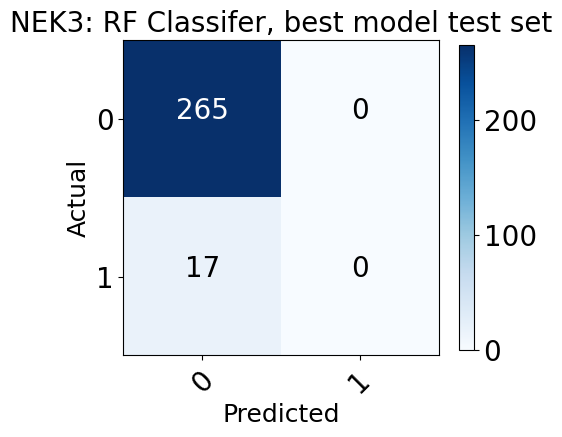

In [14]:
# Generate predictions with the best model
test_pred_y_best = best_rf.predict(test_x)

# Create the confusion matrix
test_best_cm = confusion_matrix(test_y, test_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK3: RF Classifer, best model test set",fontsize=20)
plot_confusion_matrix(test_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [15]:
accuracy = accuracy_score(test_y, test_pred_y_best)
precision = precision_score(test_y, test_pred_y_best)
recall = recall_score(test_y, test_pred_y_best)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9397163120567376
Precision: 0.0
Recall: 0.0


/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# This takes a long time. Try loading the saved model.
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,80)}

# Create a random forest classifier
rf = RandomForestClassifier(class_weight = "balanced")

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=30, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(train_x, train_y)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=30,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x286481310>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x2863d2f70>})

In [17]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)
# Best hyperparameters: {'max_depth': 34, 'n_estimators': 336}

Best hyperparameters: {'max_depth': 40, 'n_estimators': 388}


In [20]:
# Save the best model

# save
joblib.dump(best_rf, "classiferRFC_randomCV_NEK3_binding.pkl") 

# load
#clf2 = joblib.load("balanceRFC_randomCV_NEK2_binding.pkl")
#clf2.predict(X[0:1])

['classiferRFC_randomCV_NEK3_binding.pkl']

Confusion matrix, without normalization
[[1058    0]
 [   0   64]]


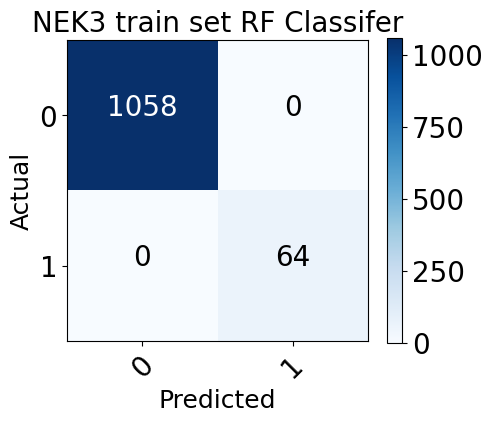

In [21]:
# Generate predictions with the best model
train_pred_y_best = best_rf.predict(train_x)

# Create the confusion matrix
train_best_cm = confusion_matrix(train_y, train_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK3 train set RF Classifer",fontsize=20)
plot_confusion_matrix(train_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


Confusion matrix, without normalization
[[265   0]
 [ 17   0]]


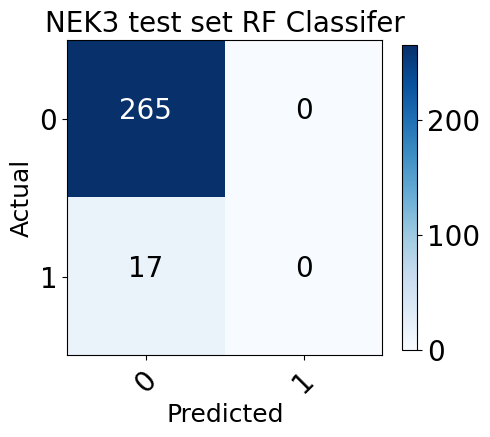

In [22]:
# Generate predictions with the best model
test_pred_y_best = best_rf.predict(test_x)

# Create the confusion matrix
test_best_cm = confusion_matrix(test_y, test_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK3 test set RF Classifer",fontsize=20)
plot_confusion_matrix(test_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);


In [23]:
accuracy = accuracy_score(test_y, test_pred_y_best)
precision = precision_score(test_y, test_pred_y_best)
recall = recall_score(test_y, test_pred_y_best)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9397163120567376
Precision: 0.0
Recall: 0.0


/Users/radhi/miniconda3/envs/atom2024/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
# This takes a very long time. Try load from the best model.
param_grid = {
    'n_estimators': np.linspace(100, 2000, 5, dtype = int),
    'max_depth': [20, 40, 60, 80, 100, 150, 200, 220],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4, 5]
}

# Base model
rf_grid = RandomForestClassifier(criterion = 'entropy', bootstrap = True)
# Instantiate the grid search model
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = 8, verbose = 2)
grid_rf_search.fit(train_x, train_y)


Fitting 5 folds for each of 480 candidates, totalling 2400 fits
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=575; total time=   2.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=575; total time=   2.7s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=575; total time=   2.8s
[CV] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=575; total time=   2.6s
[CV] END max_depth=20, min_

GridSearchCV(cv=5, estimator=RandomForestClassifier(criterion='entropy'),
             n_jobs=8,
             param_grid={'max_depth': [20, 40, 60, 80, 100, 150, 200, 220],
                         'min_samples_leaf': [2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': array([ 100,  575, 1050, 1525, 2000])},
             verbose=2)

In [26]:
best_rf_grid = grid_rf_search.best_estimator_
grid_rf_search.best_params_

{'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

Confusion matrix, without normalization
[[1058    0]
 [   4   60]]


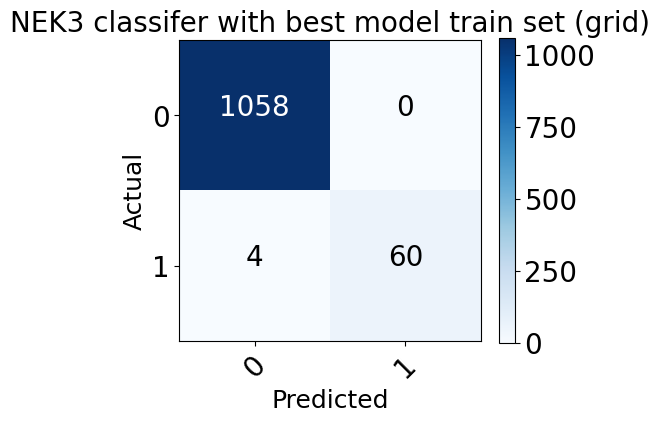

In [28]:
# Generate predictions with the best model
train_pred_y_best = best_rf_grid.predict(train_x)

# Create the confusion matrix
train_best_cm = confusion_matrix(train_y, train_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK3 classifer with best model train set (grid)",fontsize=20)
plot_confusion_matrix(train_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

Confusion matrix, without normalization
[[265   0]
 [ 17   0]]


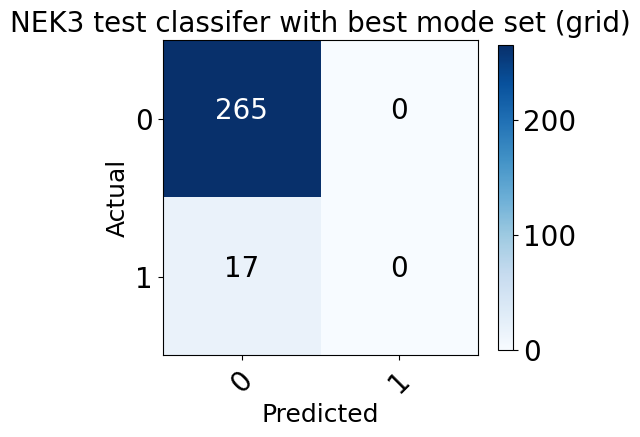

In [29]:
# Generate predictions with the best model
test_pred_y_best = best_rf_grid.predict(test_x)

# Create the confusion matrix
test_best_cm = confusion_matrix(test_y, test_pred_y_best)
class_names = ["0","1"]
plt.rcParams.update({"font.size": 20})
label_font = {'size':'18'}  # Adjust to fit

ax = plt.figure(figsize=(5,5))
plt.title("NEK3 test classifer with best mode set (grid)",fontsize=20)
plot_confusion_matrix(test_best_cm, classes=class_names, normalize=False)
plt.xlabel("Predicted",fontdict=label_font);
plt.ylabel("Actual",fontdict=label_font);

In [30]:
np.arange(len(best_rf_grid.estimators_))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [31]:
# Tree predictions
train_proba0_df = pd.DataFrame()
train_proba1_df = pd.DataFrame()
test_proba0_df = pd.DataFrame()
test_proba1_df = pd.DataFrame()

for tree_num in np.arange(len(best_rf_grid.estimators_)):
    train_proba_temp = best_rf_grid.estimators_[tree_num].predict_proba(train_x)
    train_proba0_df[tree_num] = train_proba_temp[:,0]
    train_proba1_df[tree_num] = train_proba_temp[:,1]
    test_proba_temp = best_rf_grid.estimators_[tree_num].predict_proba(test_x)
    test_proba0_df[tree_num] = test_proba_temp[:,0]
    test_proba1_df[tree_num] = test_proba_temp[:,1]
    
train_proba0_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,...,0.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,...,0.5,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.000000,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,1.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.000000,1.0,...,1.0,0.0,0.5,0.000000,1.0,0.2,0.500000,0.000000,1.0,0.0
1118,0.0,0.0,0.0,1.0,0.5,1.0,0.000000,0.0,0.333333,1.0,...,0.0,0.0,0.0,1.000000,0.0,0.0,0.000000,0.000000,0.5,1.0
1119,0.0,1.0,1.0,0.0,0.0,0.0,0.333333,0.0,1.000000,0.0,...,1.0,0.0,0.0,0.666667,1.0,1.0,0.666667,1.000000,0.0,0.0
1120,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.666667,0.0,...,0.0,1.0,0.0,0.000000,0.0,0.5,1.000000,0.333333,0.5,0.0


In [32]:
std = test_proba0_df.std(axis=1)
std

0      0.335431
1      0.177738
2      0.317828
3      0.179818
4      0.140705
         ...   
277    0.418682
278    0.156024
279    0.225201
280    0.315268
281    0.211928
Length: 282, dtype: float64

In [33]:
# Empty dataframe
train_perf_df = pd.DataFrame()
test_perf_df = pd.DataFrame()

# Predictions
train_perf_df['train_y_pred_grid'] = train_pred_y_best
test_perf_df['test_y_pred_grid'] = test_pred_y_best

# Actual
train_perf_df['train_y'] = train_y
test_perf_df['test_y'] = test_y

# Variances
train_perf_df['train_proba0_std_grid'] = train_proba0_df.std(axis=1)
train_perf_df['train_proba1_std_grid'] = train_proba1_df.std(axis=1)
test_perf_df['test_proba0_std_grid'] = test_proba0_df.std(axis=1)
test_perf_df['test_proba1_std_grid'] = test_proba1_df.std(axis=1)

train_perf_df


,train_y_pred_grid,train_y,train_proba0_std_grid,train_proba1_std_grid
0,0,0,0.174078,0.174078
1,0,0,0.213273,0.213273
2,0,0,0.156024,0.156024
3,0,0,0.171021,0.171021
4,0,0,0.000000,0.000000
...,...,...,...,...
1117,1,1,0.413762,0.413762
1118,1,1,0.437710,0.437710
1119,1,1,0.447765,0.447765
1120,1,1,0.416858,0.416858


In [34]:
# Convert probability to variance
test_perf_df['test_variance_grid'] = test_perf_df['test_proba1_std_grid'] * (1 - test_perf_df['test_proba1_std_grid'])

print(test_perf_df)

     test_y_pred_grid  test_y  test_proba0_std_grid  test_proba1_std_grid  \
0                   0       0              0.335431              0.335431   
1                   0       0              0.177738              0.177738   
2                   0       0              0.317828              0.317828   
3                   0       0              0.179818              0.179818   
4                   0       0              0.140705              0.140705   
..                ...     ...                   ...                   ...   
277                 0       1              0.418682              0.418682   
278                 0       1              0.156024              0.156024   
279                 0       1              0.225201              0.225201   
280                 0       1              0.315268              0.315268   
281                 0       1              0.211928              0.211928   

     test_variance_grid  
0              0.222917  
1              0.146147

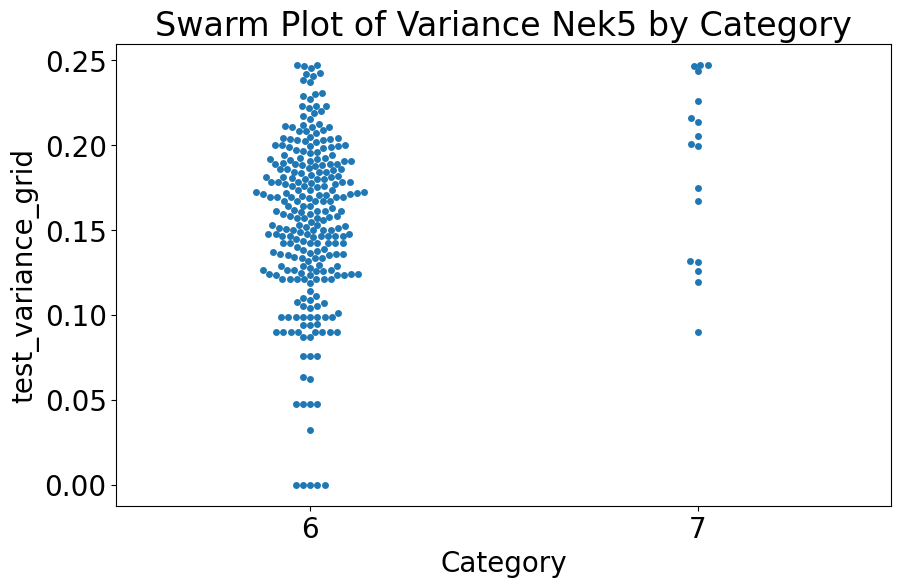

In [35]:
categories = []

for index, row in test_perf_df.iterrows():
    true = row['test_y']
    pred = row['test_y_pred_grid']
    
    if true == 0 and pred == 0:
        categories.append('6') # True Negative
    elif true == 1 and pred == 0: 
        categories.append('7') # False Negative
    elif true == 1 and pred == 1: 
        categories.append('8') # True Positive
    elif true == 0 and pred == 1:
        categories.append('9') # False Positive

test_perf_df['category'] = categories

# Now, let's plot with the updated DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

# Create the swarm plot
plt.figure(figsize=(10, 6))
sns.swarmplot(x='category', y='test_variance_grid', data=test_perf_df)

# Set labels and title
plt.xlabel('Category')
plt.ylabel('test_variance_grid')
plt.title('Swarm Plot of Variance Nek5 by Category')

# Show plot
plt.show()

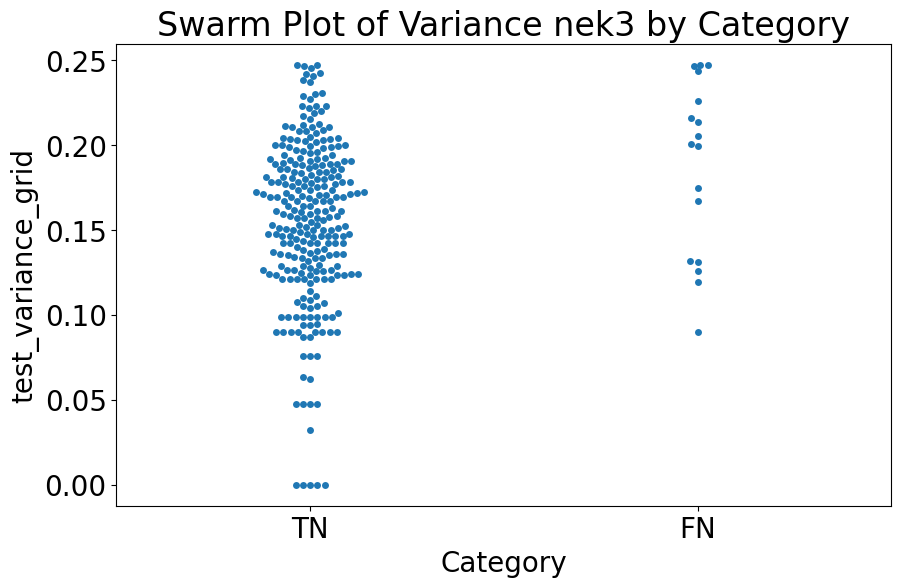

In [36]:
# Define custom labels for x-axis
custom_labels = {'6': 'TN', '7': 'FN', '8': 'TP', '9': 'FP'}

# Create the swarm plot
plt.figure(figsize=(10, 6))
sns.swarmplot(x='category', y='test_variance_grid', data=test_perf_df)

# Set labels and title
plt.xlabel('Category')
plt.ylabel('test_variance_grid')
plt.title('Swarm Plot of Variance nek3 by Category')

# Set custom labels for x-axis
plt.xticks(ticks=plt.xticks()[0], labels=[custom_labels[label.get_text()] for label in plt.gca().get_xticklabels()])

# Show plot
plt.show()